# Compare regular and core authors
We see that the active authors do not moderate their use of REs in response to an increase in collective attention. 

Is it the case that non-active or "regular" authors are more affected by the change in collective attention? This would follow under a view of "peripheral" vs. "core" community members.

In [47]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
from data_helpers import fix_timezone, round_to_day

## Load data

In [7]:
full_data_file = '../../data/mined_tweets/combined_tweet_tag_data.gz'
context_data_file = '../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz'
full_data = pd.read_csv(full_data_file, sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# load anchor data
context_data = pd.read_csv(context_data_file, sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# fix bad usernames
context_data = context_data.assign(**{'username' : context_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})
# fix date timezone problem
date_var = 'date'
full_data = full_data.assign(**{date_var : full_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
context_data = context_data.assign(**{date_var : context_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
## add rounded time var
round_date_var = '%s_day'%(date_var)
full_data = full_data.assign(**{round_date_var : full_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
context_data = context_data.assign(**{round_date_var : context_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
# compute peak times per-NE
NE_var = 'NE_fixed'
round_date_var = 'date_day'
data_name_var = 'data_name_fixed'
NE_counts = context_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
id_var = 'id'
doc_counts = full_data.groupby([data_name_var, round_date_var]).apply(lambda x: x.loc[:, id_var].nunique()).reset_index().rename(columns={0 : 'doc_count'})
NE_doc_counts = pd.merge(NE_counts, doc_counts, on=[data_name_var, round_date_var])
NE_doc_counts = NE_doc_counts.assign(**{'NE_freq' : NE_doc_counts.loc[:, 'NE_count'] / NE_doc_counts.loc[:, 'doc_count']})

In [11]:
from data_helpers import assign_peak_date
NE_min_count = 5
## limit to data with consistent NEs
# restrict to NEs that occur on at least k dates
NE_unique_date_counts = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].nunique())
NE_consistent = NE_unique_date_counts[NE_unique_date_counts >= NE_min_count].reset_index().loc[:, [data_name_var, NE_var]]
NE_doc_counts_consistent = pd.merge(NE_doc_counts, NE_consistent, on=[data_name_var, NE_var], how='inner')
# compute peaks
count_var = 'NE_count'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
context_data_consistent = pd.merge(context_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')

In [14]:
from data_helpers import assign_relative_peak_time_vars
peak_date_buffer = 1
context_data_consistent = assign_relative_peak_time_vars(context_data_consistent, peak_date_buffer)

In [17]:
import data_helpers
from importlib import reload
reload(data_helpers)
from data_helpers import compute_shift_counts
prior_freq_shift = 1
freq_null = 0.
context_data_prior_freq = []
count_var = 'NE_count_prior'
for (name_i, NE_i), data_i in context_data_consistent.groupby([data_name_var, NE_var]):
    data_i = compute_shift_counts(data_i, date_var=round_date_var, prior_shift=prior_freq_shift, count_var=count_var, null_val=freq_null)
    context_data_prior_freq.append(data_i)
context_data_prior_freq = pd.concat(context_data_prior_freq, axis=0)
context_data_consistent = context_data_prior_freq.copy()

/hg190/istewart6/crisis_language/scripts/data_processing/data_helpers.py:3199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(date_var, ascending=True, inplace=True)
/hg190/istewart6/crisis_language/scripts/data_processing/data_helpers.py:3206: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  date_counts = date_counts.loc[date_range].fillna(0, inplace=False)


Now let's compute author count distribution.

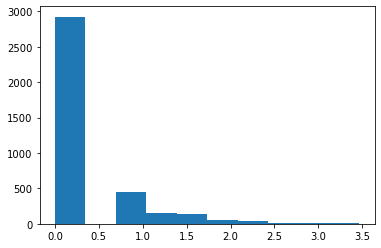

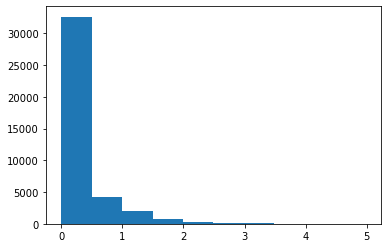

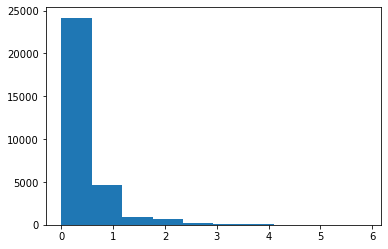

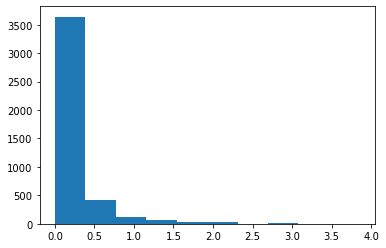

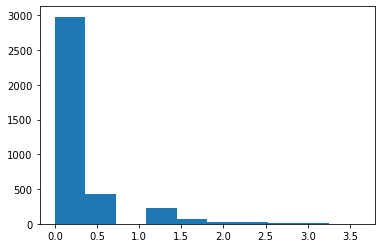

In [43]:
id_var = 'id'
author_var = 'username'
for name_i, data_i in context_data_consistent.groupby(data_name_var):
    author_counts_i = data_i.drop_duplicates([author_var, id_var], inplace=False).loc[:, author_var].value_counts()
    # log-transform
    author_counts_i = np.log(author_counts_i)
    # negative reciprocal transform??
#     author_counts_i = -(1./author_counts_i)
    # remove long trail of one-time posters
#     author_counts_i = author_counts_i[author_counts_i > 0.]
    plt.hist(author_counts_i)
    plt.show()

Maybe a better way to do this is by post volume distribution: rank authors by post volume, then select authors who are responsible for ~80\% of posts. So the same thing as before but weight the distribution.

Let's compare the anchor distribution for regular versus power authors.

In [45]:
context_var = 'anchor'
regular_cutoff_pct = 95
for name_i, data_i in context_data_consistent.groupby(data_name_var):
    print('data=%s'%(name_i))
    author_counts_i = data_i.drop_duplicates([author_var, id_var], inplace=False).loc[:, author_var].value_counts()
    # log-transform
    author_counts_i = np.log(author_counts_i)
    regular_cutoff_i = np.percentile(author_counts_i, regular_cutoff_pct)
    data_i = data_i.assign(**{
        'regular_author' : data_i.loc[:, author_var].apply(lambda x: author_counts_i.loc[x] <= regular_cutoff_i)
    })
    # compute context percents for regular/non-regular
    reg_context_pcts_i = data_i[data_i.loc[:, 'regular_author']==1].groupby(author_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean())
    non_reg_context_pcts_i = data_i[data_i.loc[:, 'regular_author']==0].groupby(author_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean())
    print('regular-author context pct %.3f +/- %.3f'%(reg_context_pcts_i.mean(), reg_context_pcts_i.std() / reg_context_pcts_i.shape[0]**.5))
    print('non-regular-author context pct %.3f +/- %.3f'%(non_reg_context_pcts_i.mean(), non_reg_context_pcts_i.std() / reg_context_pcts_i.shape[0]**.5))

data=florence
regular-author context pct 0.317 +/- 0.007
non-regular-author context pct 0.256 +/- 0.005
data=harvey
regular-author context pct 0.077 +/- 0.001
non-regular-author context pct 0.138 +/- 0.001
data=irma
regular-author context pct 0.094 +/- 0.002
non-regular-author context pct 0.106 +/- 0.001
data=maria
regular-author context pct 0.106 +/- 0.005
non-regular-author context pct 0.091 +/- 0.004
data=michael
regular-author context pct 0.230 +/- 0.007
non-regular-author context pct 0.195 +/- 0.004


No consistent patterns here at the aggregate level: sometimes the active authors lead the pack in terms of lower context (`florence`, `maria`, `michael`), sometimes not (`harvey`, `irma`).

Let's test pre/post peak differences in both author groups.

In [46]:
time_period_vars = ['pre_peak', 'post_peak']
context_var = 'anchor'
regular_cutoff_pct = 95
for name_i, data_i in context_data_consistent.groupby(data_name_var):
    print('data=%s'%(name_i))
    author_counts_i = data_i.drop_duplicates([author_var, id_var], inplace=False).loc[:, author_var].value_counts()
    # log-transform
    author_counts_i = np.log(author_counts_i)
    regular_cutoff_i = np.percentile(author_counts_i, regular_cutoff_pct)
    data_i = data_i.assign(**{
        'regular_author' : data_i.loc[:, author_var].apply(lambda x: author_counts_i.loc[x] <= regular_cutoff_i)
    })
    # compute context percents for regular/non-regular
    for time_period_var in time_period_vars:
        print('time period = %s'%(time_period_var))
        time_data_i = data_i[data_i.loc[:, time_period_var]==1]
        reg_context_pcts_i = time_data_i[time_data_i.loc[:, 'regular_author']==1].groupby(author_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean())
        non_reg_context_pcts_i = time_data_i[time_data_i.loc[:, 'regular_author']==0].groupby(author_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean())
        print('regular-author context pct %.3f +/- %.3f'%(reg_context_pcts_i.mean(), reg_context_pcts_i.std() / reg_context_pcts_i.shape[0]**.5))
        print('active author context pct %.3f +/- %.3f'%(non_reg_context_pcts_i.mean(), non_reg_context_pcts_i.std() / reg_context_pcts_i.shape[0]**.5))

data=florence
time period = pre_peak
regular-author context pct 0.314 +/- 0.014
non-regular-author context pct 0.259 +/- 0.011
time period = post_peak
regular-author context pct 0.302 +/- 0.010
non-regular-author context pct 0.247 +/- 0.008
data=harvey
time period = pre_peak
regular-author context pct 0.091 +/- 0.003
non-regular-author context pct 0.129 +/- 0.003
time period = post_peak
regular-author context pct 0.064 +/- 0.001
non-regular-author context pct 0.105 +/- 0.001
data=irma
time period = pre_peak
regular-author context pct 0.073 +/- 0.002
non-regular-author context pct 0.076 +/- 0.002
time period = post_peak
regular-author context pct 0.099 +/- 0.003
non-regular-author context pct 0.093 +/- 0.003
data=maria
time period = pre_peak
regular-author context pct 0.130 +/- 0.008
non-regular-author context pct 0.088 +/- 0.006
time period = post_peak
regular-author context pct 0.103 +/- 0.008
non-regular-author context pct 0.091 +/- 0.007
data=michael
time period = pre_peak
regular-a

In general, both regular and active authors show a consistent decrease in context use, except for `irma` authors.

## Load clean data
Let's clean the regular-author data in the same way that we cleaned the power author data.

In [11]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
from data_helpers import fix_timezone, round_to_day, assign_peak_date, assign_relative_peak_time_vars

In [2]:
full_data_file = '../../data/mined_tweets/combined_tweet_tag_data.gz'
context_data_file = '../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz'
full_data = pd.read_csv(full_data_file, sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# load anchor data
context_data = pd.read_csv(context_data_file, sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# fix bad usernames
context_data = context_data.assign(**{'username' : context_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})
# fix date timezone problem
date_var = 'date'
full_data = full_data.assign(**{date_var : full_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
context_data = context_data.assign(**{date_var : context_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
## add rounded time var
round_date_var = '%s_day'%(date_var)
full_data = full_data.assign(**{round_date_var : full_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
context_data = context_data.assign(**{round_date_var : context_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
# compute NE counts
NE_var = 'NE_fixed'
round_date_var = 'date_day'
data_name_var = 'data_name_fixed'
NE_counts = context_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
id_var = 'id'
doc_counts = full_data.groupby([data_name_var, round_date_var]).apply(lambda x: x.loc[:, id_var].nunique()).reset_index().rename(columns={0 : 'doc_count'})
NE_doc_counts = pd.merge(NE_counts, doc_counts, on=[data_name_var, round_date_var])
NE_doc_counts = NE_doc_counts.assign(**{'NE_freq' : NE_doc_counts.loc[:, 'NE_count'] / NE_doc_counts.loc[:, 'doc_count']})

In [3]:
## compute author counts per dataset
## limit to authors <= 95th percentile
regular_author_data_clean = []
data_name_var = 'data_name_fixed'
author_var = 'username'
author_cutoff_pct = 95
for name_i, data_i in context_data.groupby(data_name_var):
    author_counts_i = np.log(data_i.loc[:, author_var].value_counts())
    author_cutoff_i = np.percentile(author_counts_i, author_cutoff_pct)
    data_i = data_i[data_i.loc[:, author_var].apply(lambda x: author_counts_i.loc[x] <= author_cutoff_i)]
    regular_author_data_clean.append(data_i)
regular_author_data_clean = pd.concat(regular_author_data_clean, axis=0)
print('%d/%d consistent data'%(regular_author_data_clean.shape[0], context_data.shape[0]))
regular_author_data = regular_author_data_clean.copy()

114914/163366 consistent data


In [6]:
# restrict to consistent NEs
NE_min_count = 5
NE_unique_date_counts = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].nunique())
NE_consistent = NE_unique_date_counts[NE_unique_date_counts >= NE_min_count].reset_index().loc[:, [data_name_var, NE_var]]
NE_doc_counts_consistent = pd.merge(NE_doc_counts, NE_consistent, on=[data_name_var, NE_var], how='inner')
count_var = 'NE_count'
NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
context_data_consistent = pd.merge(context_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
# merge with regular author data
regular_author_data_consistent = pd.merge(regular_author_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
print('%d/%d consistent data'%(regular_author_data_consistent.shape[0], regular_author_data.shape[0]))

107437/114914 consistent data


In [9]:
## what is NE overlap in data?? why can't we merge??
shared_NEs = set(regular_author_data_consistent.loc[:, NE_var].unique()) & set(context_data_consistent.loc[:, NE_var].unique())
print('%d/%d NEs shared'%(len(shared_NEs), context_data_consistent.loc[:, NE_var].nunique()))

1078/1082 NEs shared


In [26]:
peak_date_buffer = 1
## assign peak times
context_data_consistent_peaks = assign_relative_peak_time_vars(context_data_consistent, peak_date_buffer)
# deduplicate
context_data_consistent_peaks.drop_duplicates([id_var, NE_var], inplace=True)
time_period_vars = ['pre_peak', 'during_peak', 'post_peak']
id_var = 'id'
print('about to merge peak data: N=%d'%(context_data_consistent_peaks.shape[0]))
regular_author_data_consistent_peaks = pd.merge(regular_author_data_consistent, context_data_consistent_peaks.loc[:, [id_var, NE_var, data_name_var]+time_period_vars], on=[id_var, NE_var, data_name_var], how='inner')

about to merge peak data: N=145913


In [25]:
display(context_data_consistent_peaks.loc[:, [NE_var, data_name_var]+time_period_vars].head())

,NE_fixed,data_name_fixed,pre_peak,during_peak,post_peak
0,raleigh,florence,1,0,0
1,raleigh,florence,1,0,0
2,raleigh,florence,1,0,0
3,raleigh,florence,1,0,0
4,raleigh,florence,1,0,0


In [65]:
print(sorted(regular_author_data_consistent.columns))
print(sorted(context_data_consistent_peaks.columns))

['NE', 'NE_LOC', 'NE_fixed', 'NE_fixed_clean', 'NE_type', 'anchor', 'anchor_phrase', 'data_name_fixed', 'date', 'date_day', 'has_descriptor', 'id', 'lang', 'max_alternate_name_count', 'max_alternate_name_count_anchor', 'max_alternate_name_count_diff', 'max_alternate_names', 'max_population', 'max_population_anchor', 'max_population_diff', 'parse', 'peak_date', 'txt', 'username', 'valid_loc']
['NE', 'NE_LOC', 'NE_fixed', 'NE_fixed_clean', 'NE_type', 'anchor', 'anchor_phrase', 'data_name_fixed', 'data_start', 'date', 'date_day', 'during_peak', 'has_descriptor', 'id', 'lang', 'max_alternate_name_count', 'max_alternate_name_count_anchor', 'max_alternate_name_count_diff', 'max_alternate_names', 'max_population', 'max_population_anchor', 'max_population_diff', 'parse', 'peak_date', 'post_peak', 'pre_peak', 'since_peak', 'since_start', 'txt', 'username', 'valid_loc']
